# Solve for casing current in a halfspace

The method of moments can be used to model the effect of conductive casings in electromagnetic surveys. This approach replaces the casing with a series of current sources. To make this replacement, we must find the current in the casing. The problem can be formulated as a linear system of equations $AJ = b$, where $A$ is a matrix that describes casing interactions, $J$ is the vector of current densities for each casing segment that we want to solve for, and $b$ is a vector of values of the electric field induced by our survey's source at each casing segment.

In [1]:
#%matplotlib widget
import numpy as np
import matplotlib.pyplot as plt

# add parent directory to path
import os, sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import halfspace as hs

Let's define some problem-specific parameters

In [2]:
frequency = 1
background_conductivity = 0.18
casing_conductivity = 1.0e7
outer_radius=0.1095
inner_radius=0.1095-0.0134
casing_length=1365
num_segments=280

In [3]:
%%time
A = hs.form_A(
    frequency=frequency,
    background_conductivity=background_conductivity,
    casing_conductivity=casing_conductivity,
    outer_radius=outer_radius,
    inner_radius=inner_radius,
    casing_length=casing_length,
    num_segments=num_segments)


CPU times: user 10.5 s, sys: 39.3 ms, total: 10.5 s
Wall time: 10.6 s


The matrix $A$ is num_segments by num_segments

In [4]:
A.shape

(280, 280)

Is A Hermitian? If all casing elements are of equal length, then it should be! Let's use a dot product test to check.

In [5]:
u = np.random.random(len(A)) + 1j*np.random.random(len(A))
v = np.random.rand(len(A)) + 1j*np.random.random(len(A))
np.matmul(np.matmul(u,A),v)-np.matmul(v,np.matmul(A,u))

(2.168404344971009e-18-1.1058862159352145e-17j)

Close enough.

Now, define a wire path for the source, from (0,0) to (2000,0)

In [6]:
wire_length = 2000
wire_segment_length = 10
num_wire_segments = int(np.ceil(wire_length/wire_segment_length))
wire_path_x = np.linspace(0,wire_length,num_wire_segments+1)
wire_path_y = np.zeros(num_wire_segments+1)

Solve for Ez at the casing due to the wire

In [7]:
b = hs.form_b(
    wire_path_x,
    wire_path_y,
    wire_current = 1,
    frequency=frequency,
    background_conductivity=background_conductivity,
    casing_length=casing_length,
    num_segments=num_segments)

Solve for the current densities

In [8]:
%%time
J = np.linalg.solve(A,b)

CPU times: user 27.3 ms, sys: 2.88 ms, total: 30.2 ms
Wall time: 8.72 ms


Each element of j is the current density of one casing segment.

In [9]:
J.shape

(280,)

Since we assume current density to be constant in each segment, current in each segment is simply current density times cross-sectional area.

In [10]:
casing_area = np.pi*(outer_radius**2-inner_radius**2)
I = J*casing_area

Plot the current in the casing as a function of depth

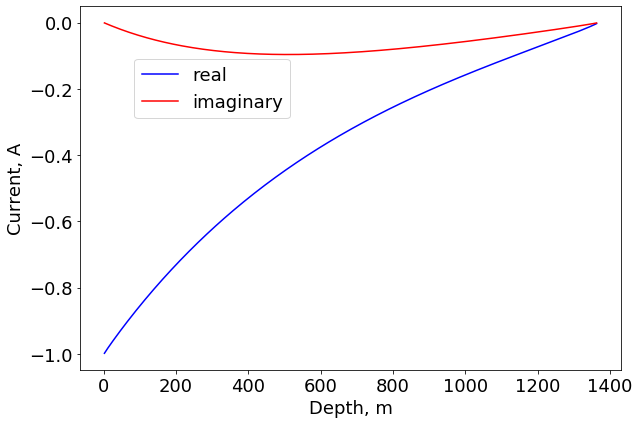

In [11]:
dz = casing_length/num_segments
zs = np.linspace(dz/2,casing_length-dz/2,num_segments)

real_color = 'b'
imag_color = 'r'
font_size = 18

fig = plt.figure(figsize=(9,6))
ax = plt.subplot()
ax.plot(zs,np.real(I),color=real_color)
ax.plot(zs,np.imag(I),color=imag_color)
ax.figure.legend(['real','imaginary'],fontsize=font_size,loc=(0.21,0.72))

ax.set_xlabel('Depth, m',fontsize=font_size)
ax.set_ylabel('Current, A',fontsize=font_size)
ax.tick_params(axis='both', which='major', labelsize=font_size)
plt.tight_layout()

plt.show()